# Analysis

In [2]:
cd ..

/Users/casperneo/work/cloud-research/clouds


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports are relative to `clouds/`
from reproduction.pipeline import load as pipeline
from reproduction.analysis import img_scatter

import os
import tensorflow as tf
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE

/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Load Data

In [4]:
img_width = 64
batch_size = 32
use_hdf_data = False

In [5]:
def has_data(null_value, threshold):
    def fn(x):
        nulls = tf.equal(x, null_value)
        null_freq = tf.reduce_mean(tf.cast(nulls, tf.float32))
        return null_freq < threshold
    return fn

### TIF Data

In [6]:
tiff_files = ["data/tif/2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.tif"]
n_bands = 7
tif_fields = ["b%d"%(i+1) for i in range(n_bands)]
tif_dataset = (
    tf.data.Dataset.from_generator(
        pipeline.read_tiff_gen(tiff_files, img_width),
        tf.int16,
        (img_width, img_width, n_bands)
    )
    .filter(has_data(0, 0.3))
    .apply(tf.contrib.data.shuffle_and_repeat(100))
    .apply(batch_and_drop_remainder(batch_size))
)

### HDF data

In [7]:
meta_json = "experimental/test/ex.json"
hdf_fields = ['Cloud_Optical_Thickness', "Cloud_Water_Path", "Cloud_Effective_Radius"]#, "Single_Scatter_Albedo_Ice", "Single_Scatter_Albedo_Liq"]
data_files = ["experimental/test/ex.tfrecord"]

chans, parser = pipeline.main_parser(hdf_fields, meta_json)
hdf_dataset = (
    tf.data.Dataset.from_tensor_slices(data_files)
    .apply(shuffle_and_repeat(100))
    .flat_map(tf.data.TFRecordDataset)
    .map(parser)
    .interleave(pipeline.patchify_fn(img_width, img_width, chans), cycle_length=4)
    .map(lambda x: tf.clip_by_value(x, 0, 15000))
    .shuffle(10000)
    .apply(batch_and_drop_remainder(batch_size))
)

### Load

In [8]:
if use_hdf_data:
    dataset = hdf_dataset
    fields = hdf_fields
else:
    dataset = tif_dataset
    fields = tif_fields

x = dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    y = sess.run(x)

### Plot

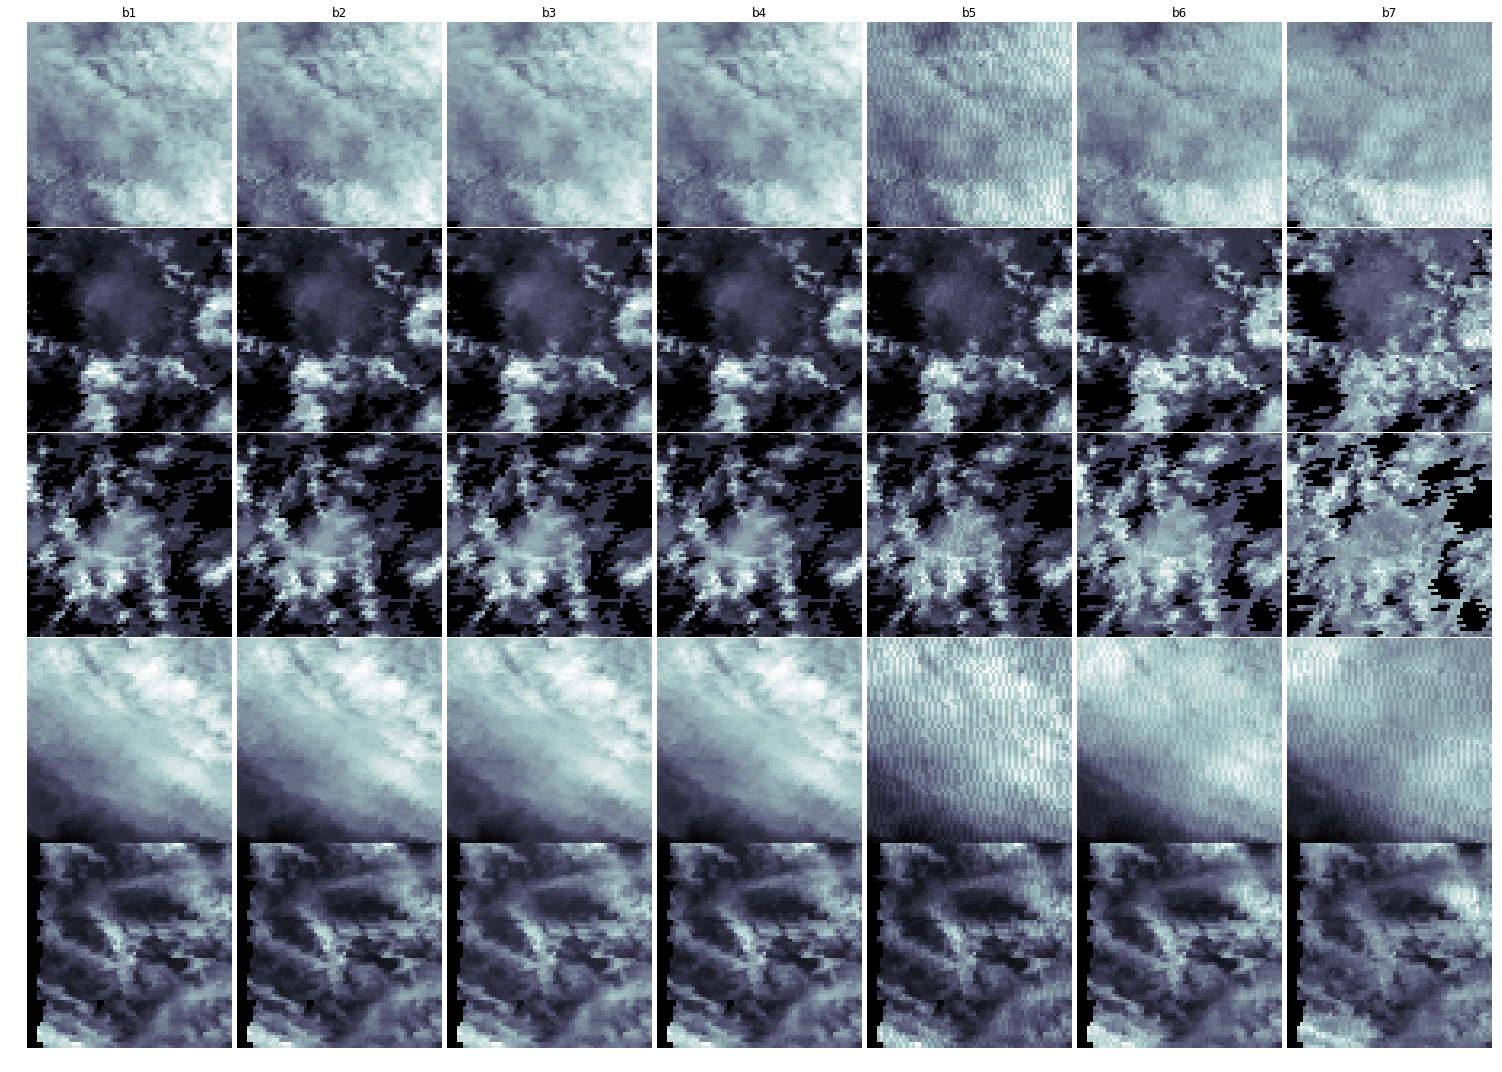

In [9]:
samples = 5
width = 3
fig, ax = plt.subplots(
    nrows=samples,
    ncols=len(fields),
    figsize=(len(fields) * width, samples * width),
)
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
for r in range(samples):
    for c, field in enumerate(fields):
        a = ax[r, c]
        a.imshow(y[r,:,:,c], cmap="bone")
        a.set_axis_off()
        if r == 0:
            a.set_title(field)

fig.tight_layout(w_pad=-2, h_pad=-2)

### Plot histogram of channel distribution

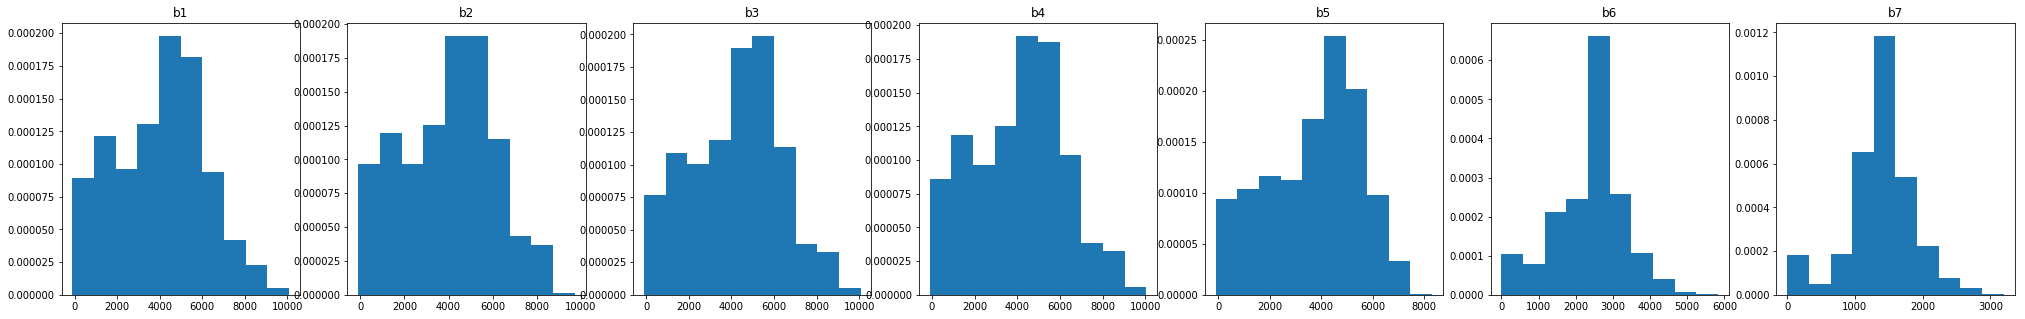

In [10]:
fig, ax = plt.subplots(ncols=len(fields), figsize=(len(fields) * 5, 5))

for i, f in enumerate(fields):
    a = ax[i]
    a.hist(y[:,:,:,i].flatten(), density=True)
    a.set_title(f)

## Load Model

In [140]:
model_dir = "output/m9/"
!head -n 20 output/m9/run-m9.sbatch_4294967294.out

Tensorflow version: 1.9.0
Current Git Commit: b'fb66c8f'
Flags:
	data:                      ['/project/foster/clouds/geotfr/1_of_8.tfrecords', '/project/foster/clouds/geotfr/2_of_8.tfrecords', '/project/foster/clouds/geotfr/3_of_8.tfrecords', '/project/foster/clouds/geotfr/4_of_8.tfrecords', '/project/foster/clouds/geotfr/5_of_8.tfrecords', '/project/foster/clouds/geotfr/6_of_8.tfrecords', '/project/foster/clouds/geotfr/7_of_8.tfrecords', '/project/foster/clouds/geotfr/8_of_8.tfrecords']
	batch_size:                32
	model_dir:                 out/m9/
	optimizer:                 adam
	steps_per_epoch:           1000
	epochs:                    500
	new_model:                 
	shape:                     (64, 64, 7)
	discriminator:             
	lambda_disc:               0.01
	lambda_gradient_penalty:   10
	n_critic:                  5
	perceptual:                None


Starting epoch 0
Starting epoch 1


In [139]:
with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (InputLayer)        (None, 64, 64, 7)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
__________

### Autoencoder output
Each column is a field (labeled), each row triplet of rows is a sample. The triplets are original, difference, and autoencoded

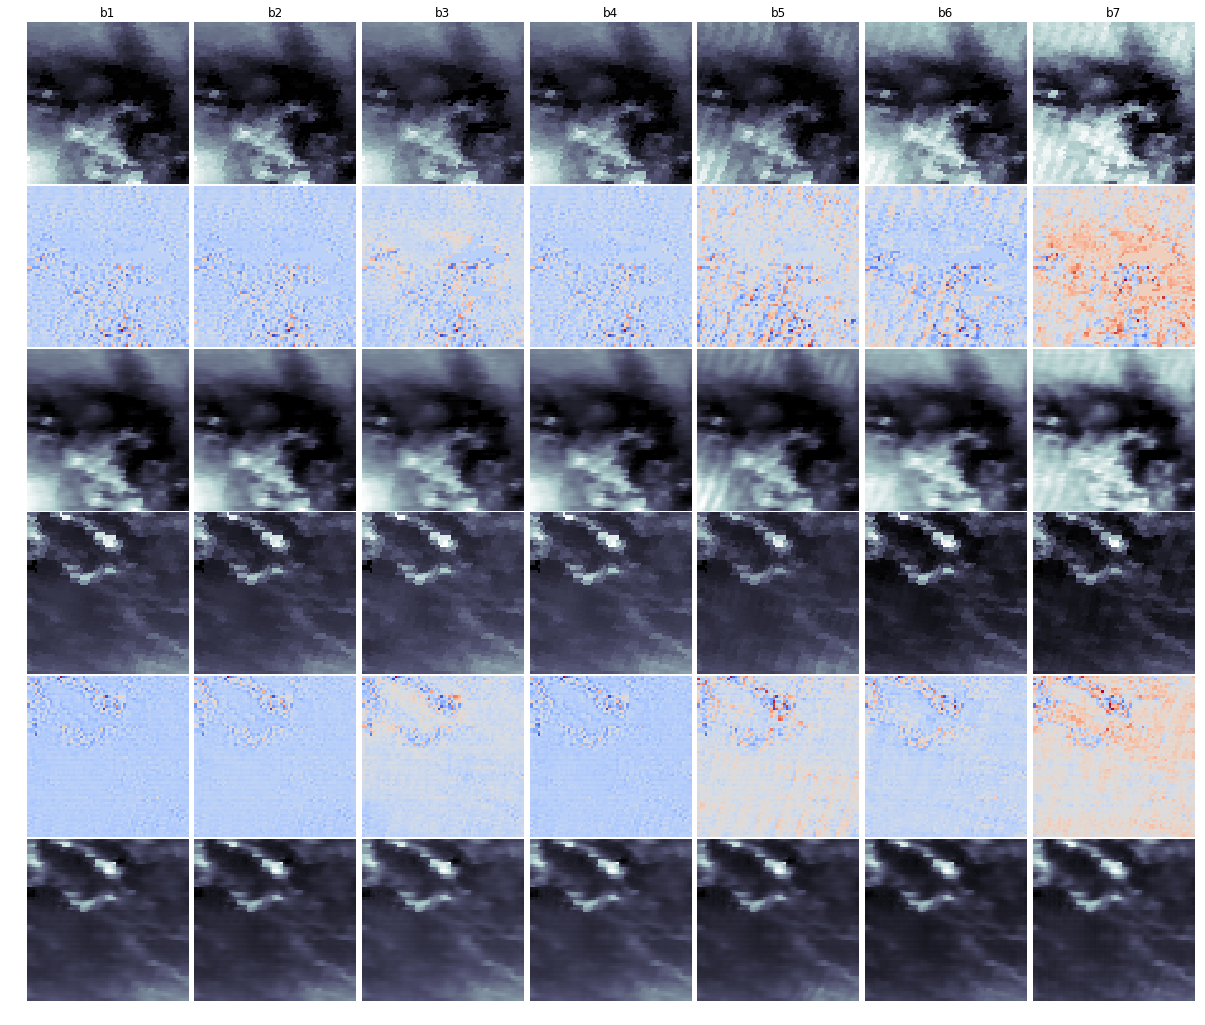

In [142]:
enc, dec = ae.predict(y.astype(np.float32))

samples = 2
width = 3
fig, ax = plt.subplots(
    nrows=samples * 3,
    ncols=len(fields),
    figsize=(len(fields) * width, samples * width * 3)
)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for s in range(samples):
    for c, field in enumerate(fields):
        orig = ax[s * 3, c]
        orig.imshow(y[s,:,:, c], cmap="bone")
        if s == 0: orig.set_title(field)
        
        diff = ax[s * 3 + 1, c]
        diff.imshow(y[s,:,:, c] - dec[s, :, :, c], cmap="coolwarm")
            
        out = ax[s * 3 + 2, c]
        out.imshow(dec[s, :, :, c], cmap="bone")
for a in ax.flatten():
    a.set_axis_off()

## Analysis

### Get more data 

In [151]:
n = 3200

imgs = []
with tf.Session() as sess:
    for _ in range(n // batch_size):
        imgs.append(sess.run(x))
        
encodings = []
for y in imgs:
    enc, _ = ae.predict(y.astype(np.float32))
    encodings.extend(list(enc.mean(axis=(1,2))))

tmp = []
for i in imgs:
    tmp.extend(list(i))
imgs = np.array(tmp)
encodings = np.array(encodings)

### Compute PCA

In [152]:
centered = encodings - encodings.mean(axis=0)
cov = centered.transpose().dot(centered) / centered.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.flip(evals)
evecs = np.flip(evecs, axis=1)

#### Principle Components and $R^2$

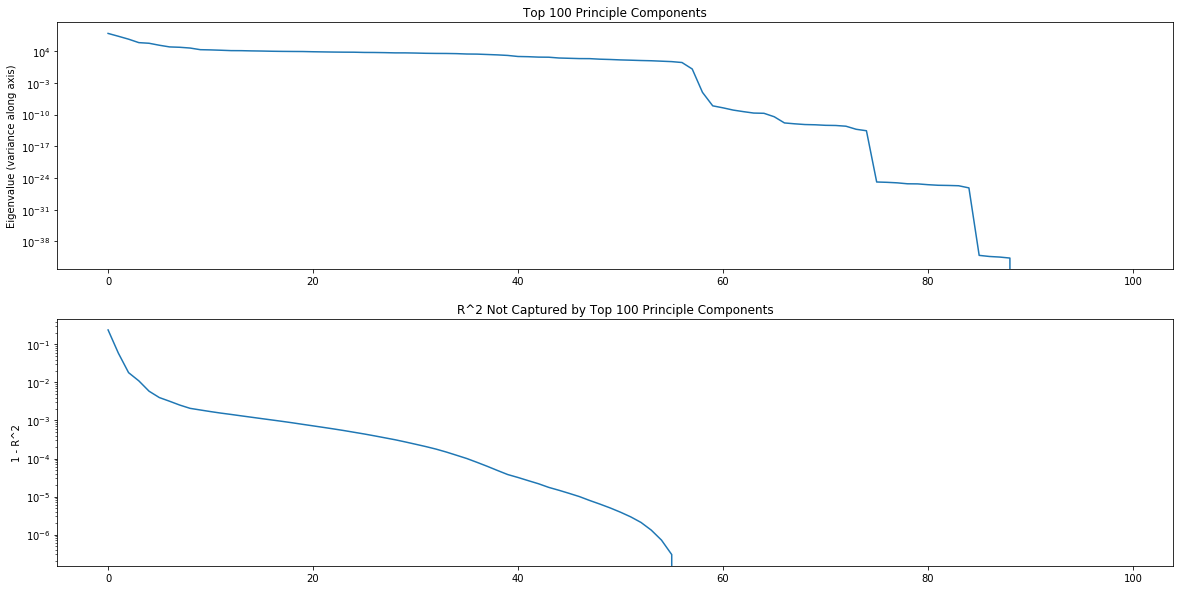

In [170]:
D = 100
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(evals[:D])
ax1.set_title("Top %d Principle Components"% D)
ax1.set_yscale("log")
ax1.set_ylabel("Eigenvalue (variance along axis)")

ax2.plot(1 - evals.cumsum()[:D] / evals.sum())
ax2.set_title("R^2 Not Captured by Top %d Principle Components"%D)
ax2.set_yscale("log")
ax2.set_ylabel("1 - R^2");

### PCA Projection

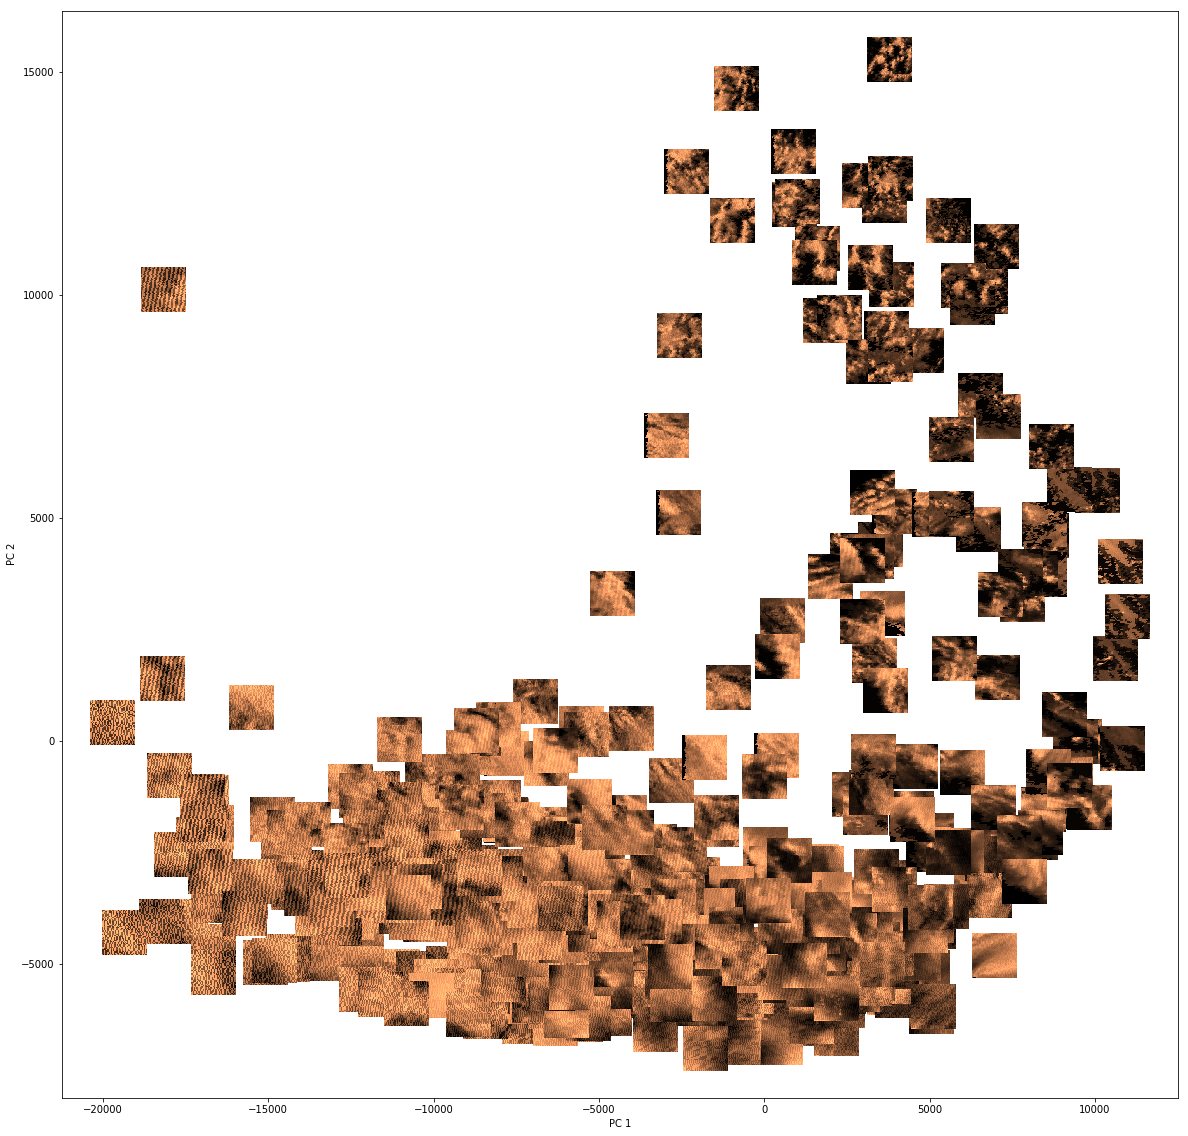

In [173]:
N = 500
# This is zero indexed
dimensions = [0, 1]

projected = centered.dot(evecs[:, dimensions])
fig, ax = img_scatter(
    projected[:N], 
    [y[:,:,4] for y in imgs[:N]],
    zoom=0.7
)
ax.set_xlabel("PC %d"%(dimensions[0] + 1))
ax.set_ylabel("PC %d"%(dimensions[1] + 1));

### T-SNE Projection

In [155]:
N = 500
dims = 50
projected = centered[:N,:].dot(evecs[:, :dims])
embedding = TSNE(n_components=2).fit_transform(projected)

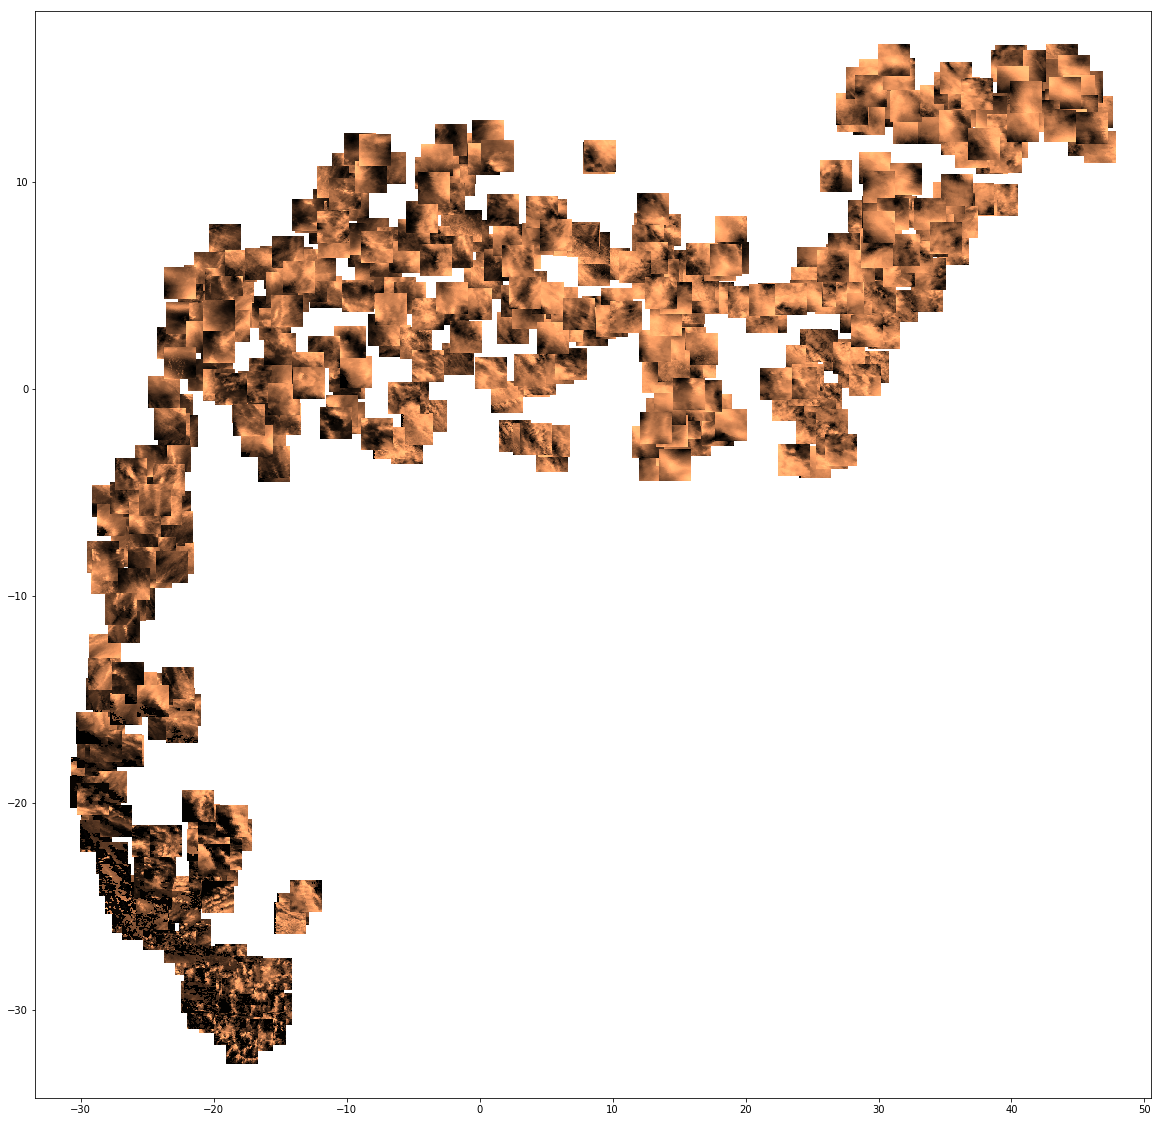

In [156]:
fig, ax = img_scatter(
    embedding,
    [y[:,:,0] for y in imgs[:N]],
)

# Cluster Analysis

In [157]:
from sklearn import cluster
import pandas as pd
from reproduction.analysis import plot_cluster_channel_distributions, plot_cluster_samples

In [158]:
n_clusters = 10
sc = cluster.SpectralClustering(n_clusters, affinity="nearest_neighbors").fit(encodings)
km = cluster.KMeans(n_clusters).fit(encodings)
imgs = np.array(imgs)

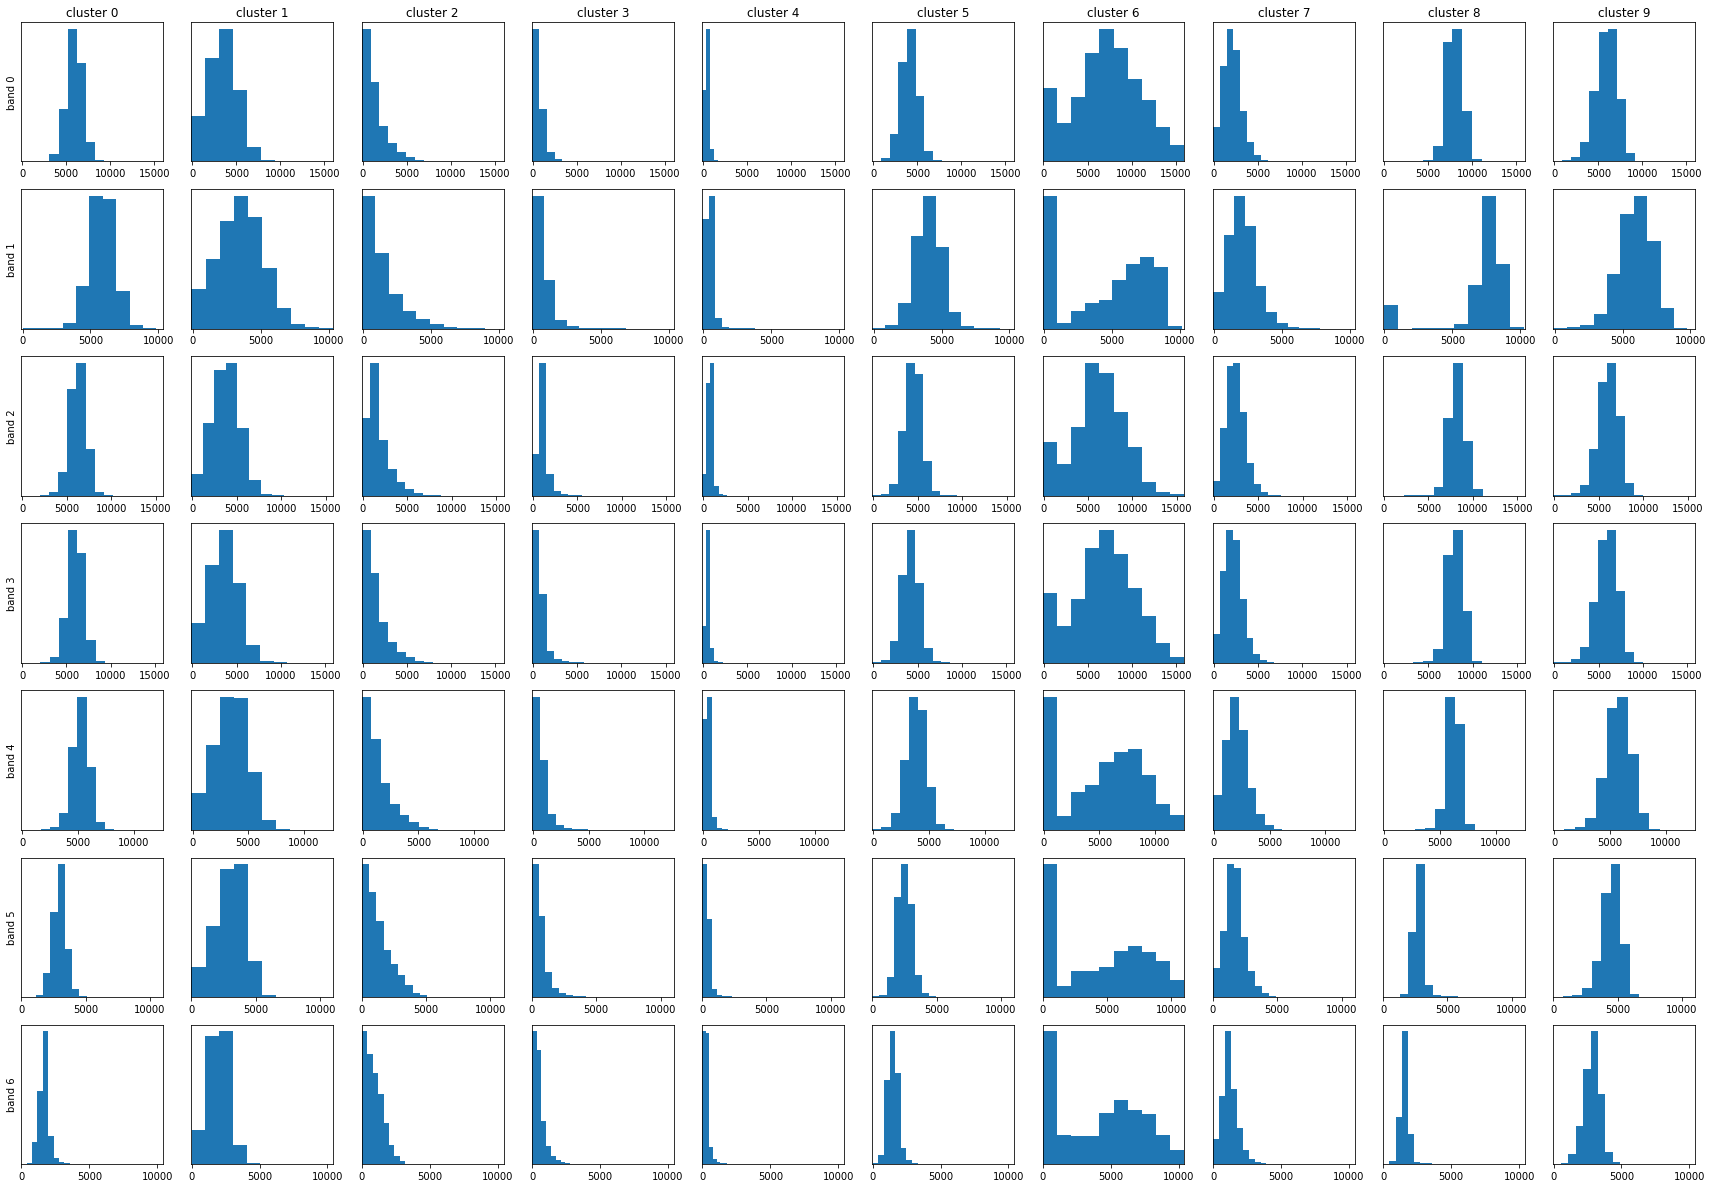

In [159]:
fig, ax = plot_cluster_channel_distributions(imgs, sc.labels_)

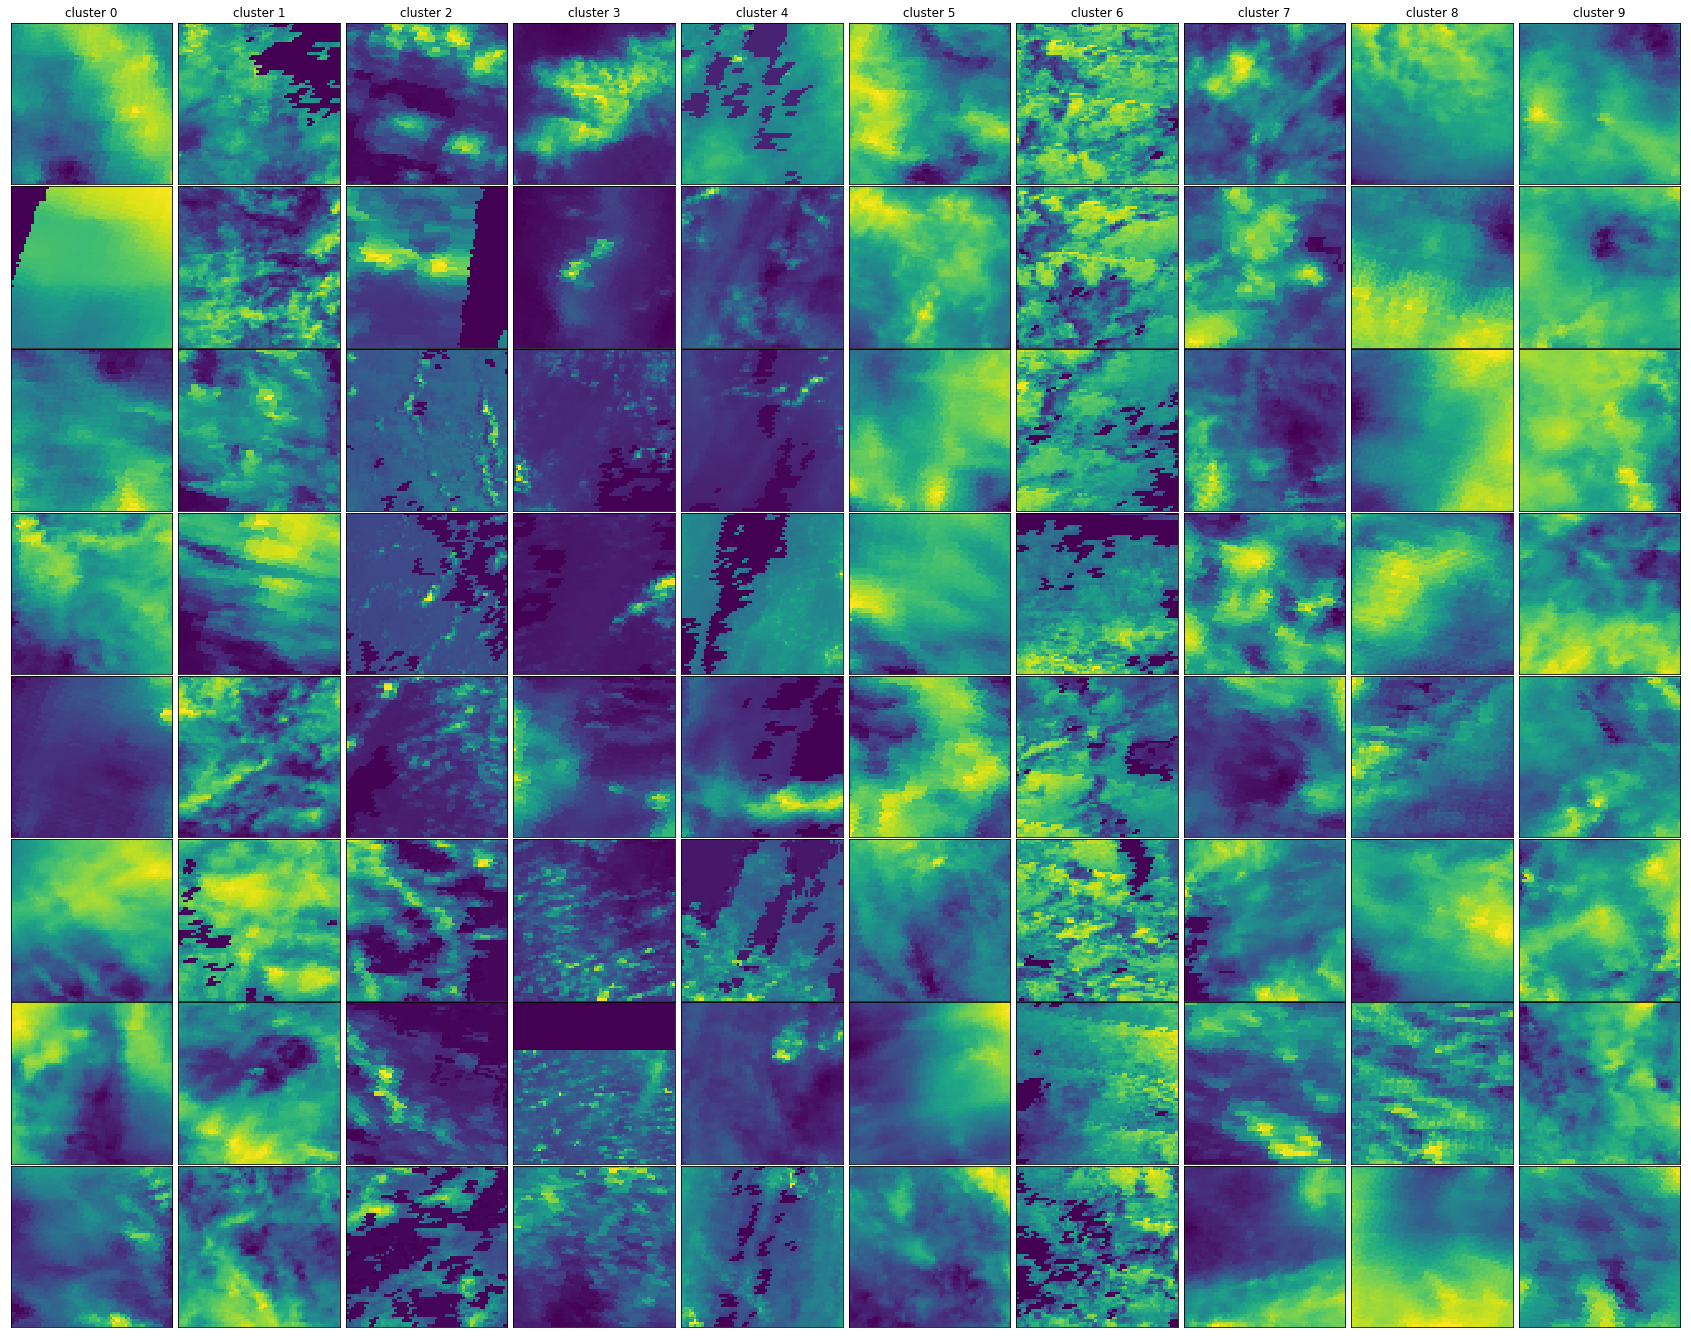

In [160]:
fig, ax = plot_cluster_samples(imgs, sc.labels_)

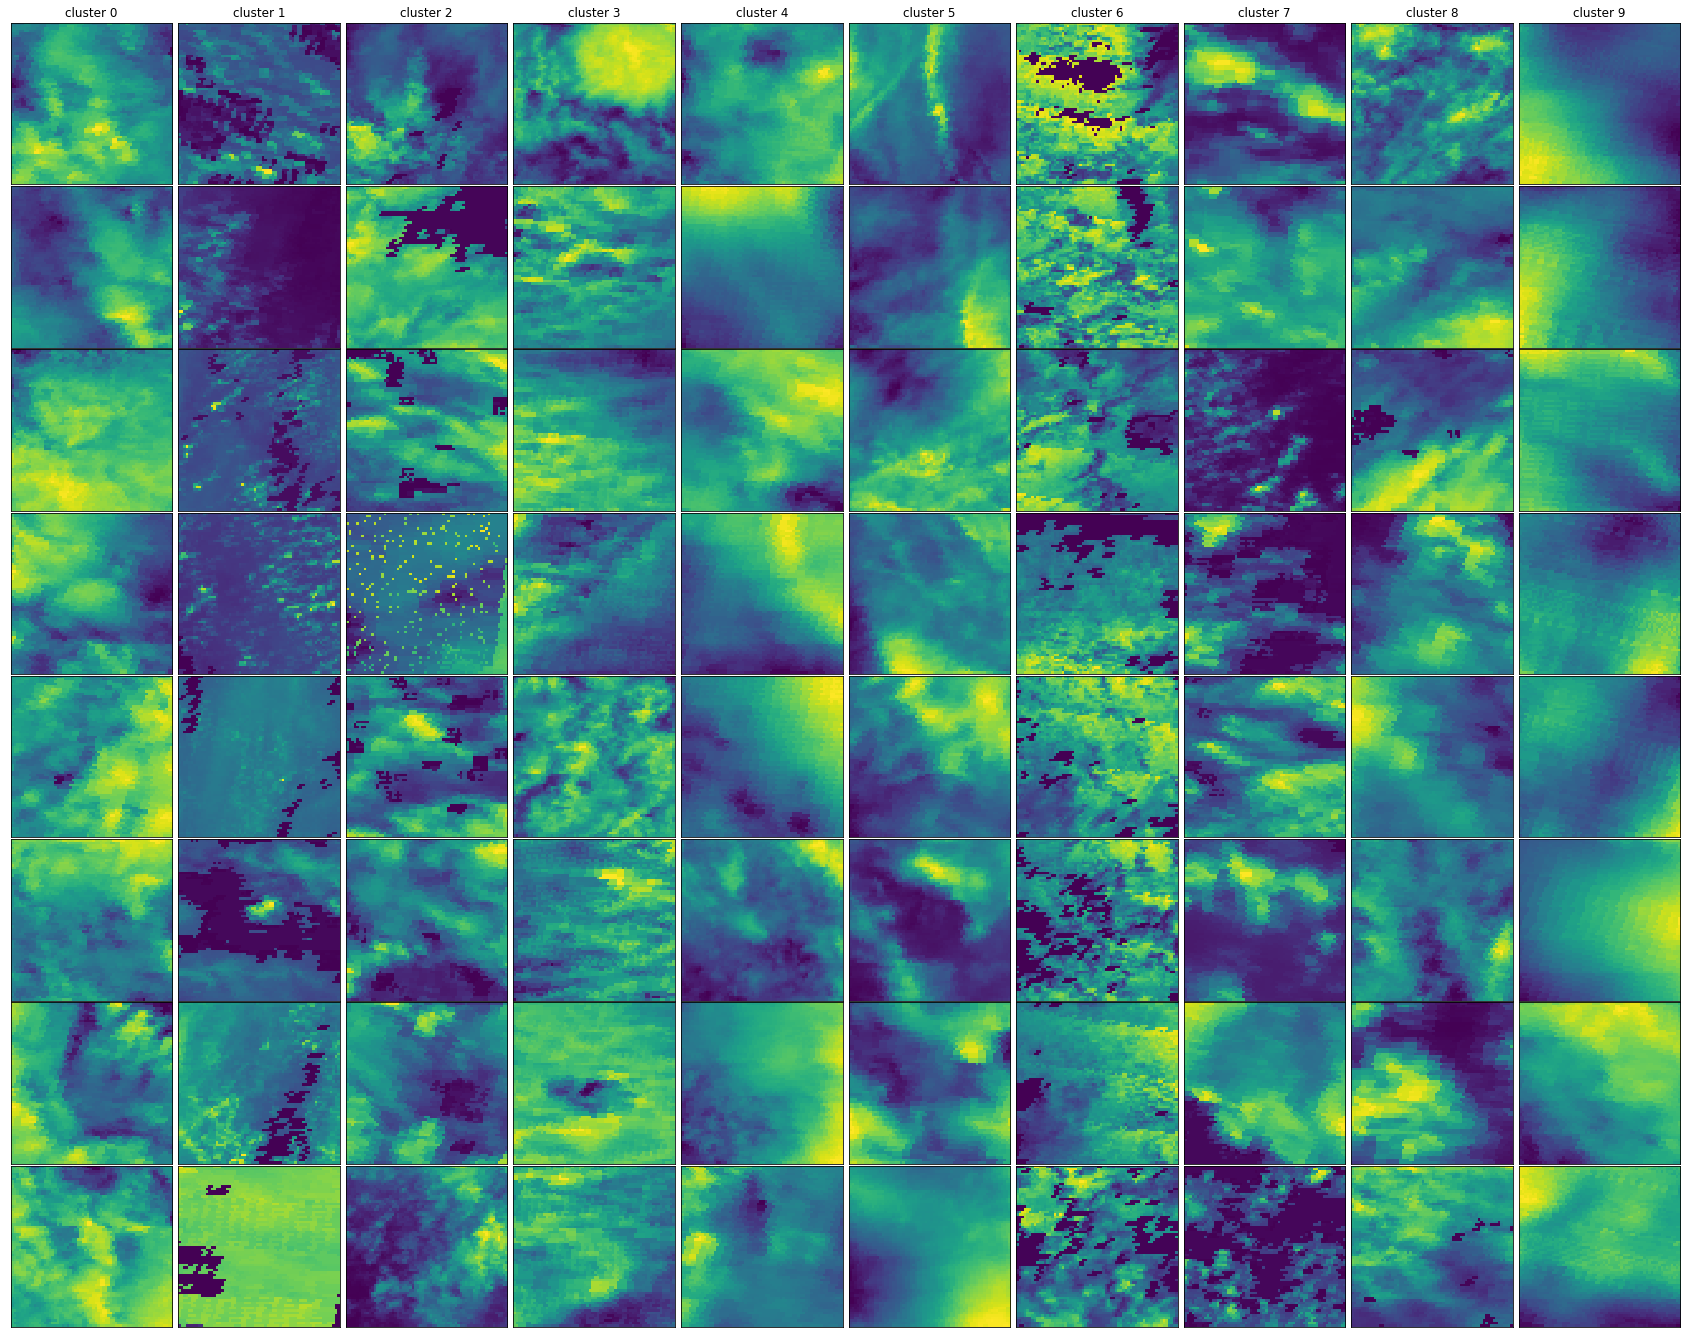

In [161]:
fig, ax = plot_cluster_samples(imgs, km.labels_)

Text(0.5,0,'PC 3')

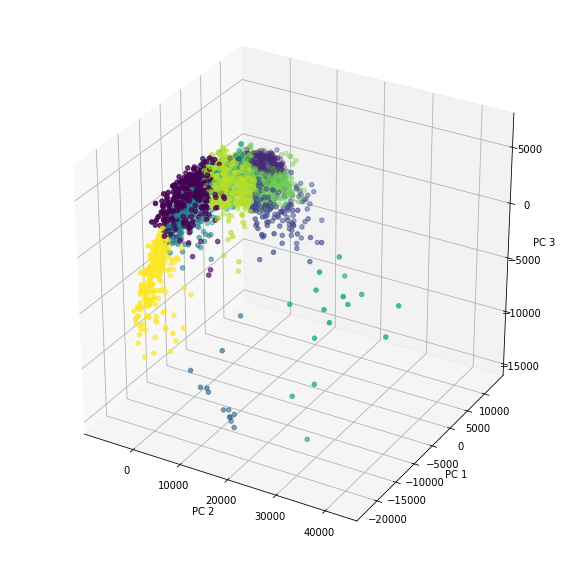

In [342]:
dim = (1,0,2)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

xs_, ys_, zs_ = zip(*centered.dot(evecs[:,dim]))

ax.scatter(xs_, ys_, zs_, c=km.labels_)
ax.set_xlabel("PC %d"%(dim[0] + 1))
ax.set_ylabel("PC %d"%(dim[1] + 1))
ax.set_zlabel("PC %d"%(dim[2] + 1))
# ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]);

Looking at the PCA projection, it seems the AE does not seperate different cloud types but rather embeds most kinds of clouds into a single manifold, this perhaps rules out density based clustering techniques

### Cluster similarity Analysis

In [162]:
sc.labels_

array([0, 7, 5, ..., 3, 7, 9], dtype=int32)

In [209]:
def clusterfy(labels):
    n_clusters = len(set(labels))
    clusters = [set() for _ in range(n_clusters)]
    for i, l in enumerate(labels):
        clusters[l].add(i)
    return clusters

def jaccard_similarity(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

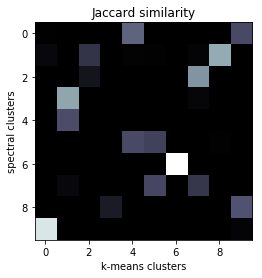

In [312]:
c1 = clusterfy(sc.labels_)
c2 = clusterfy(km.labels_)

s = np.zeros((len(c1), len(c2)))
for i, a in enumerate(c1):
    for j, b in enumerate(c2):
        s[i, j] =  jaccard_similarity(a, b)
plt.ylabel("spectral clusters")
plt.xlabel("k-means clusters")
plt.title("Jaccard similarity")
plt.imshow(s, cmap="bone")

A white square means there is a large similarity between the clusters while black means no clustering. Two clustering methods are consistent with each other if this is mostly black and white. Jaccard similarity is defined 

$$\frac{|A\cap B|}{|A\cup B|}$$

### TODO Similarity metrics for unlabeled data
* Silhouette Coefficient
* Calinski-Harabaz Index

### TODO Intra-cluster interpolation visualization